# Preprocessing

In [169]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
%autoreload 2

In [171]:
import torch

In [216]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
import json


In [173]:
connection = Connection()
# Get client
client = connection.get_client()

In [174]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [175]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [176]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [177]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [345]:
df_train, df_val, df_test = get_blocked_temporal_train_val_test_split(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=559, Validation=60, Test=136


In [346]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [347]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry,)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.4541


In [349]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.5666486861922353,
   'mae': 18.827173944090074,
   'rmse': 22.099577449105986,
   'mape (%)': 22.083750220491755,
   'mpe (%)': 7.550408101619269},
  'qw': {'r2': 0.008505317373473598,
   'mae': 1.0610561042383275,
   'rmse': 1.3848153425220364,
   'mape (%)': 1344.8156550328667,
   'mpe (%)': 1311.0509801227727},
  'qg': {'r2': 0.7265194848143675,
   'mae': 1913.2972585630243,
   'rmse': 2195.14743800364,
   'mape (%)': 14.441529891746901,
   'mpe (%)': -14.015075504356641},
  'wgr': {'r2': -2.3000779545665266,
   'mae': 9.019260202685531e-05,
   'rmse': 0.00014404259175152591,
   'mape (%)': 346.79059427127487,
   'mpe (%)': 319.90359465335916},
  'gor': {'r2': -565.8264228071773,
   'mae': 16.759115048103922,
   'rmse': 31.331692735226422,
   'mape (%)': 13.69223507485625,
   'mpe (%)': -13.244024366645906}},
 'W08': {'qo': {'r2': -0.16067715197905597,
   'mae': 7.229211255763164,
   'rmse': 8.673405897574344,
   'mape (%)': 47.84424528550563,
   'mpe (%)': 4

In [350]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.7617463895511476,
   'mae': 14.338353050484931,
   'rmse': 16.3864039401483,
   'mape (%)': 12.535112263805564,
   'mpe (%)': -6.3693147740743115},
  'qw': {'r2': -1.2977801030778204,
   'mae': 1.584335770030703,
   'rmse': 2.1081470645024614,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.9200047419252428,
   'mae': 922.4041370498423,
   'rmse': 1187.2238769337132,
   'mape (%)': 7.6840670564739115,
   'mpe (%)': -4.876398453562249},
  'wgr': {'r2': -2.1694347310469713,
   'mae': 0.0001167890489498043,
   'rmse': 0.00014116262765388968,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -281.85882775485715,
   'mae': 16.63381529630376,
   'rmse': 22.133173275447632,
   'mape (%)': 13.558509687894443,
   'mpe (%)': 3.612074628233554}},
 'W08': {'qo': {'r2': -0.6583808995503342,
   'mae': 7.514065294357269,
   'rmse': 10.36754900406337,
   'mape (%)': 49.97659113122738,
   'mpe (%)': 28.923919109381675},
  'qw': {'r2': 0.9631776903262601,

In [351]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9800090834515578,
   'mae': 4.074841029900929,
   'rmse': 4.7465740900916575,
   'mape (%)': 3.0783599217007813,
   'mpe (%)': 2.9252540655690678},
  'qw': {'r2': -1.1246945749270263,
   'mae': 1.522499587383007,
   'rmse': 2.027192198872264,
   'mape (%)': 93.0459062673395,
   'mpe (%)': -93.0459062673395},
  'qg': {'r2': 0.9412673176887613,
   'mae': 699.5590523766087,
   'rmse': 1017.2797937318155,
   'mape (%)': 4.630534971464361,
   'mpe (%)': 4.630534971464361},
  'wgr': {'r2': -1.965096040539268,
   'mae': 0.00011221433760626176,
   'rmse': 0.0001365363252363793,
   'mape (%)': 92.42933019753676,
   'mpe (%)': -92.42933019753676},
  'gor': {'r2': -21.560082154378115,
   'mae': 4.286633707205667,
   'rmse': 6.250707170976325,
   'mape (%)': 3.4590635731329105,
   'mpe (%)': 1.6751663916651627}},
 'W08': {'qo': {'r2': 0.7251412431369625,
   'mae': 3.5132616802564187,
   'rmse': 4.220741380311052,
   'mape (%)': 21.402150405142603,
   'mpe (%)': -5.749455342

In [352]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

In [353]:
p = model.phys_models["W19"].params_
print(p["C_gl"])


1.7036629467739947e-20


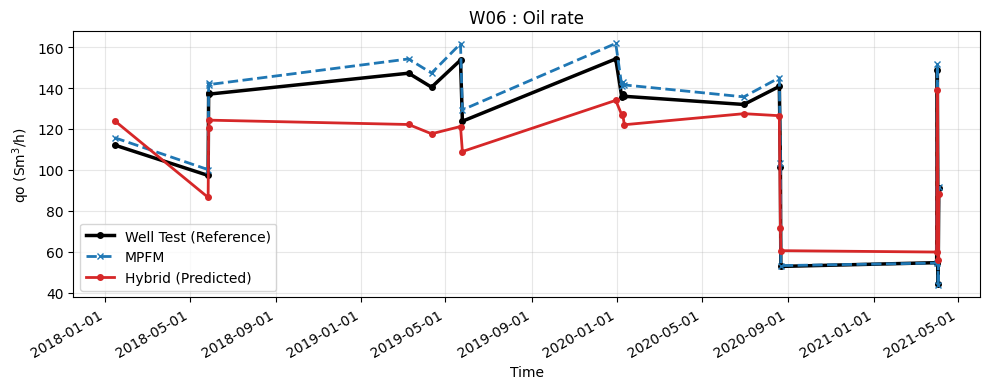

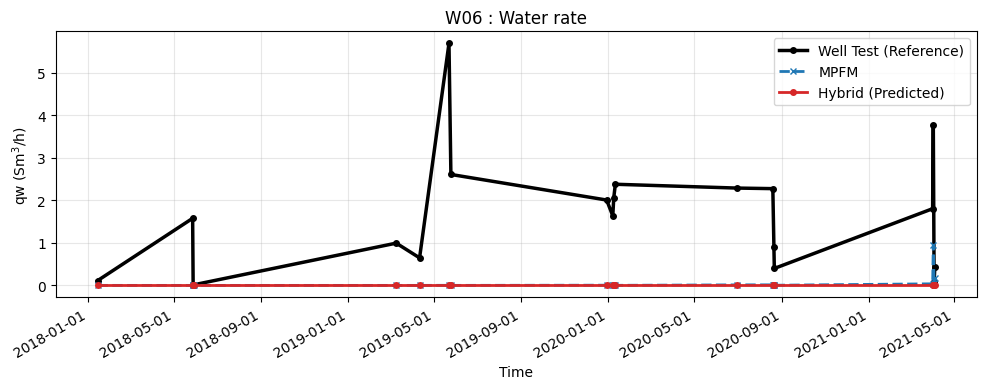

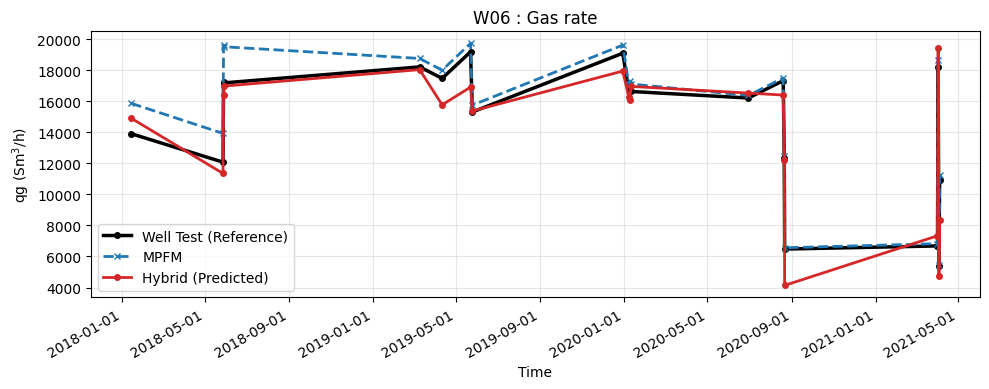

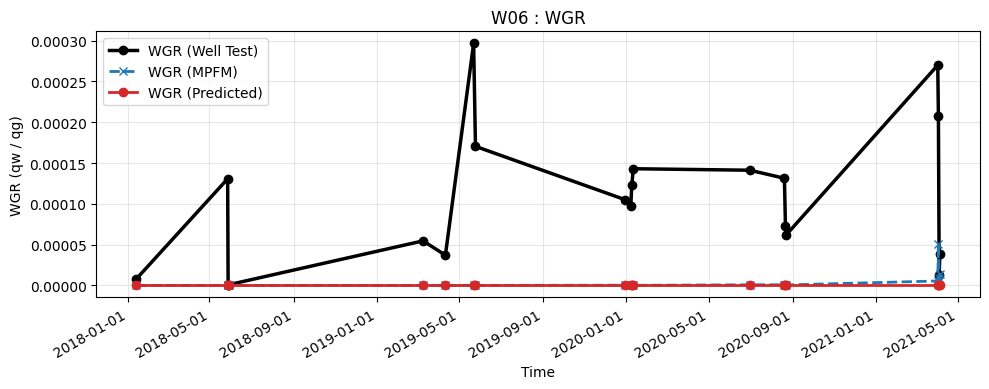

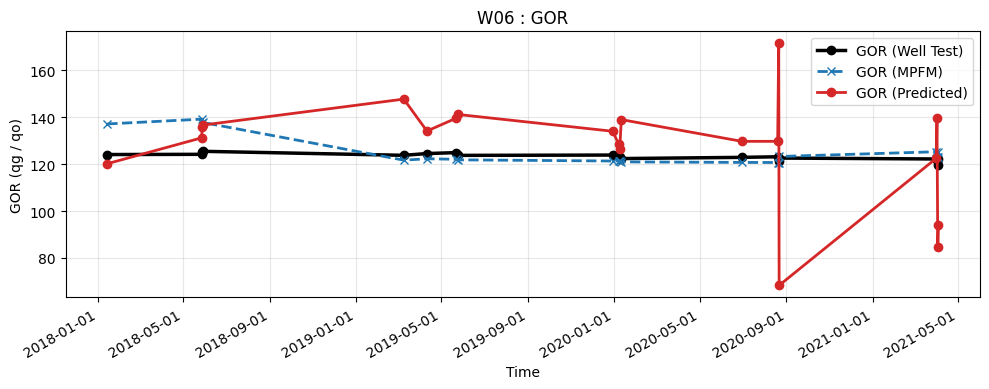

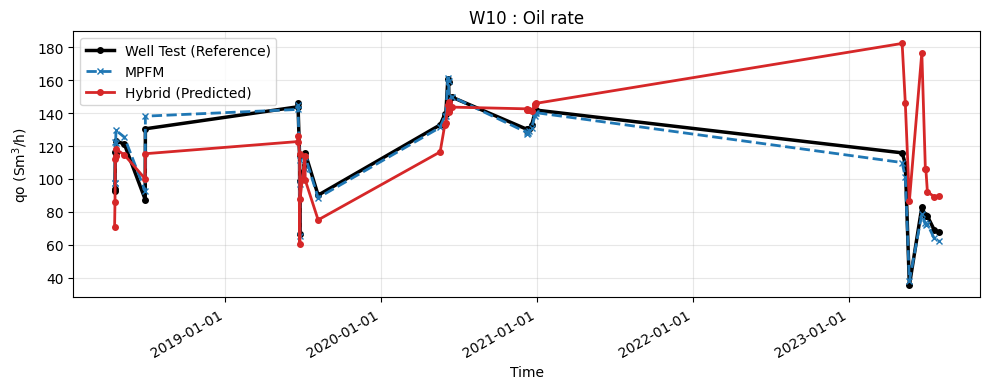

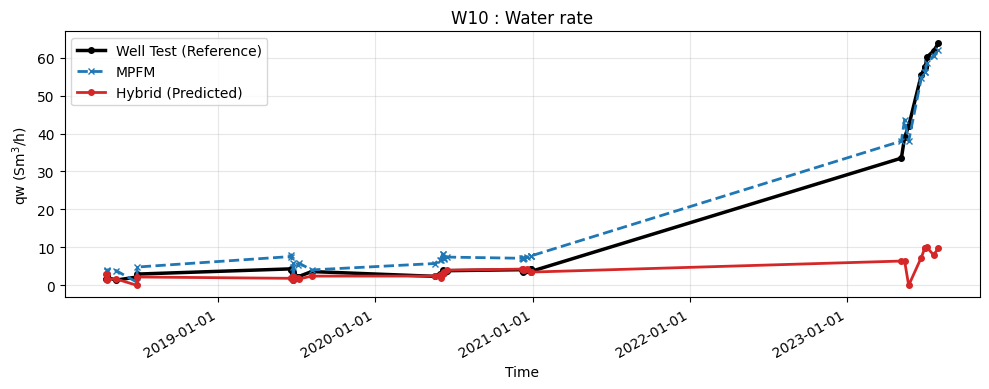

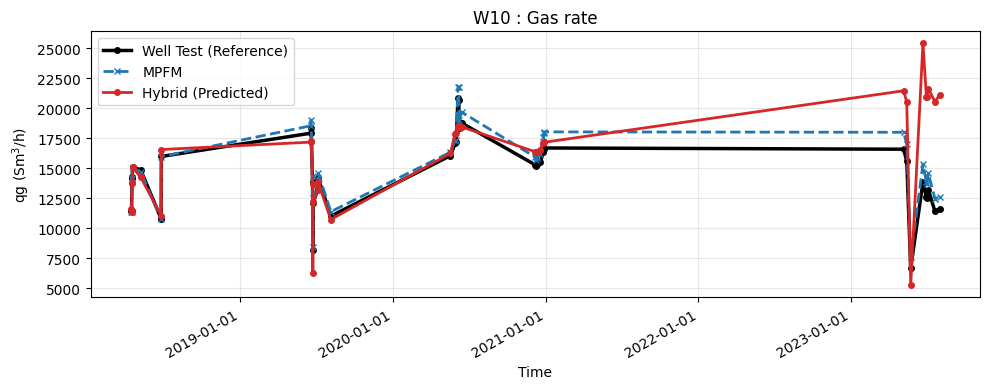

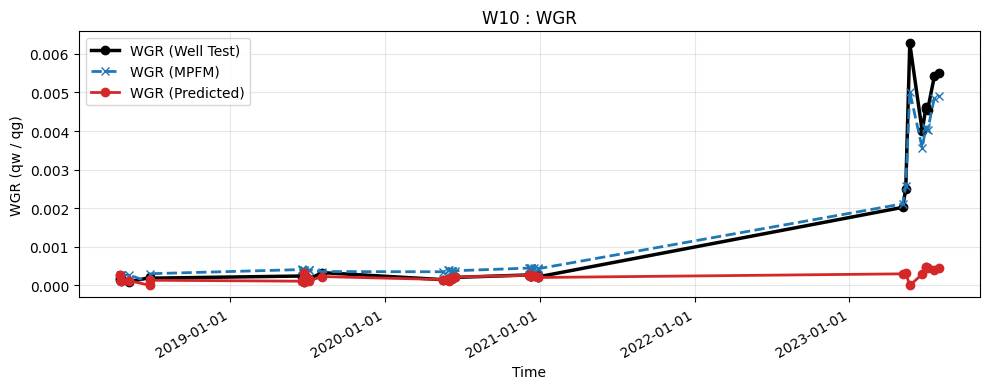

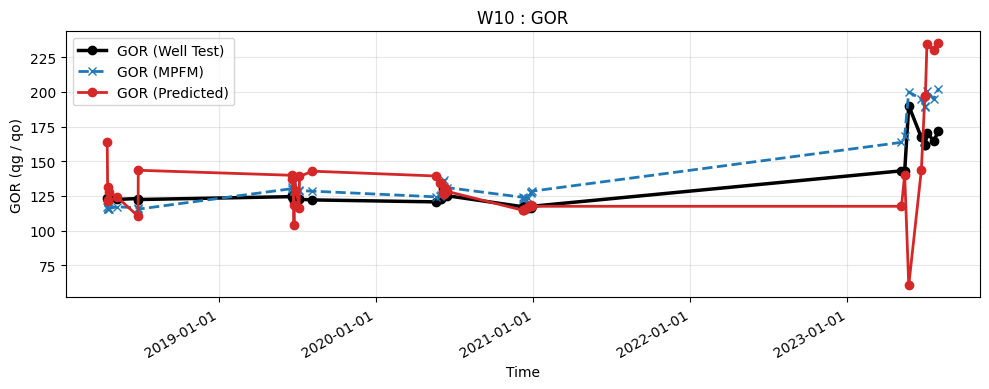

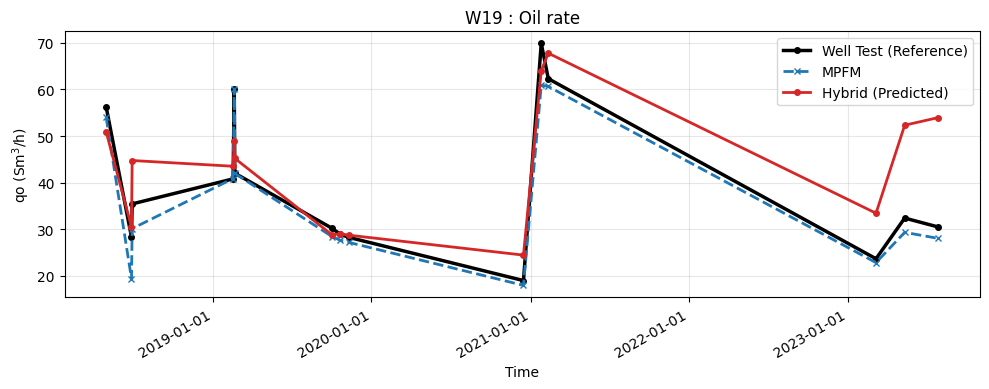

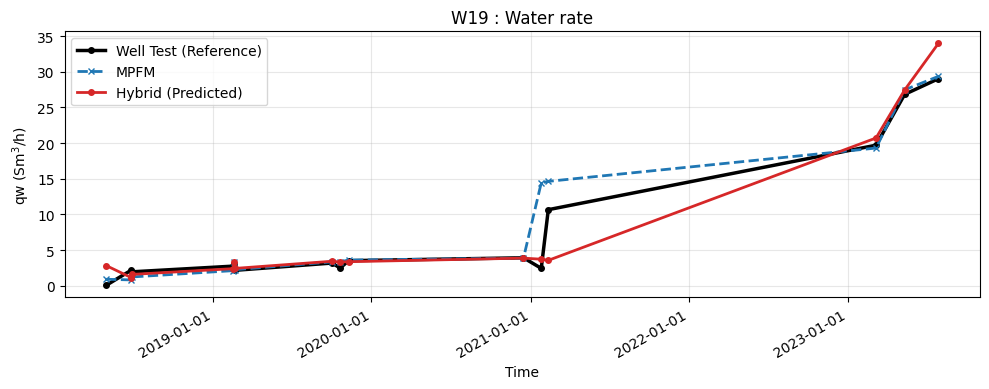

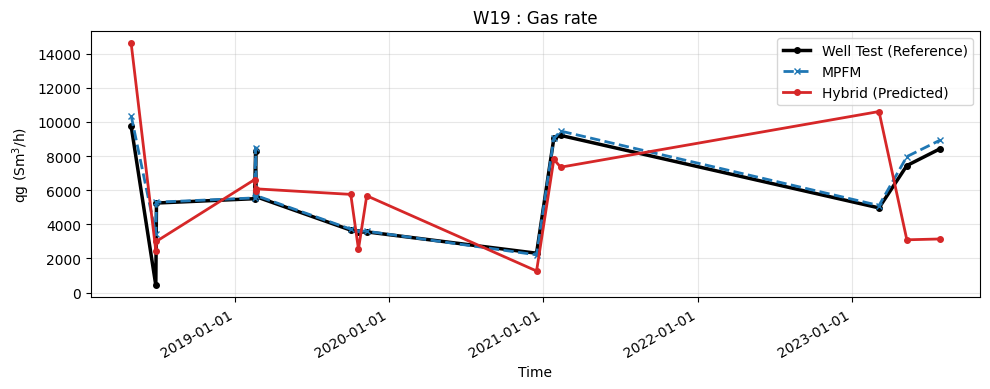

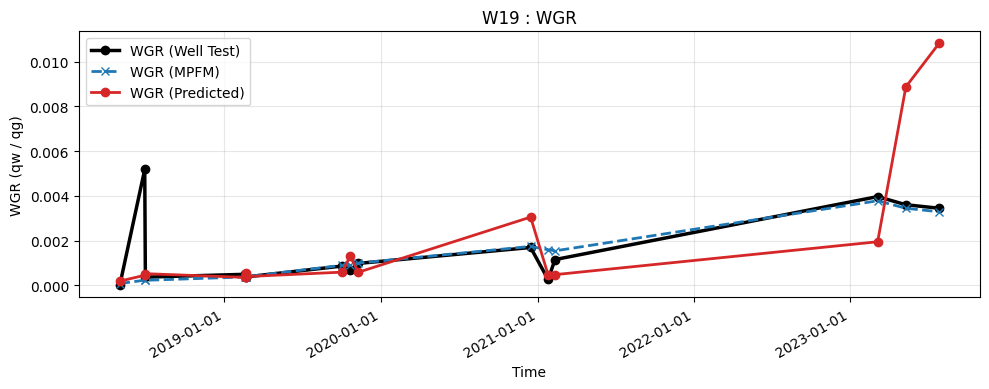

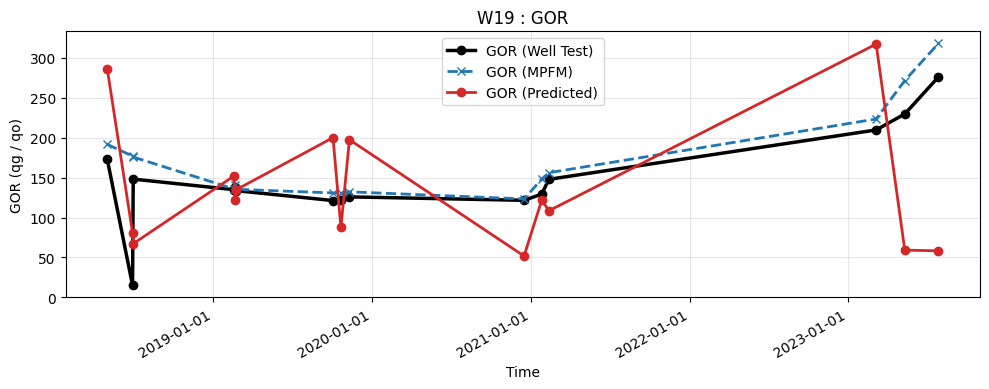

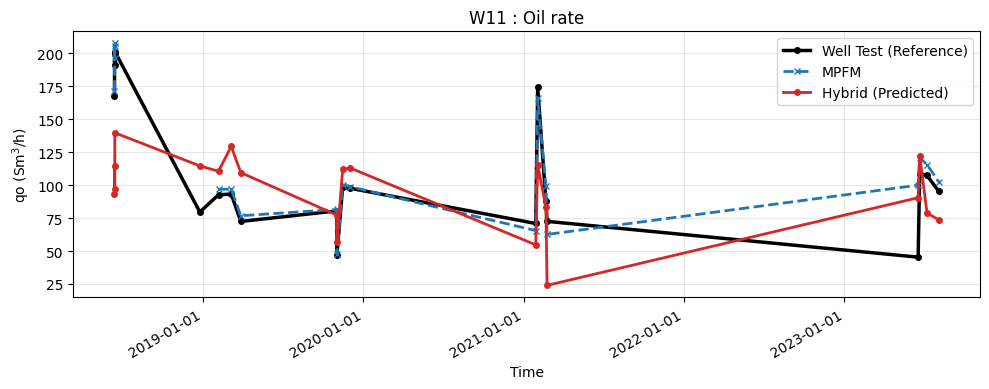

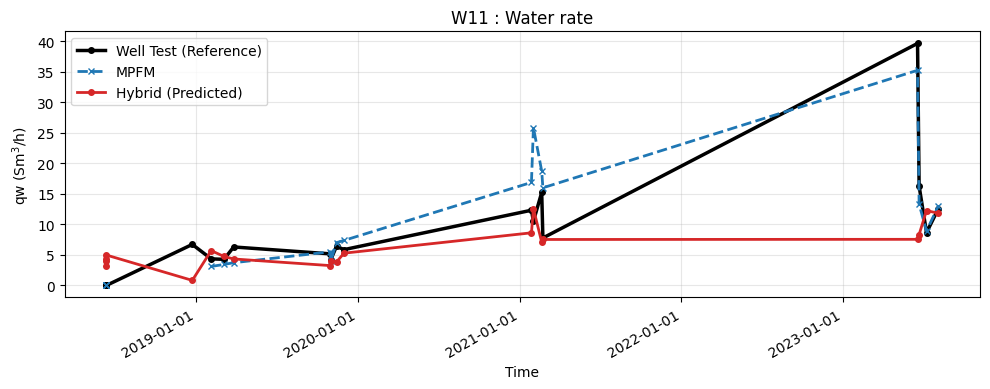

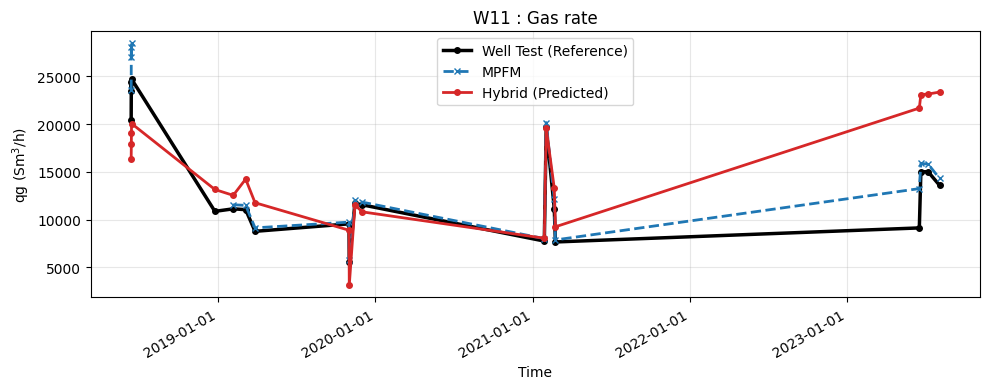

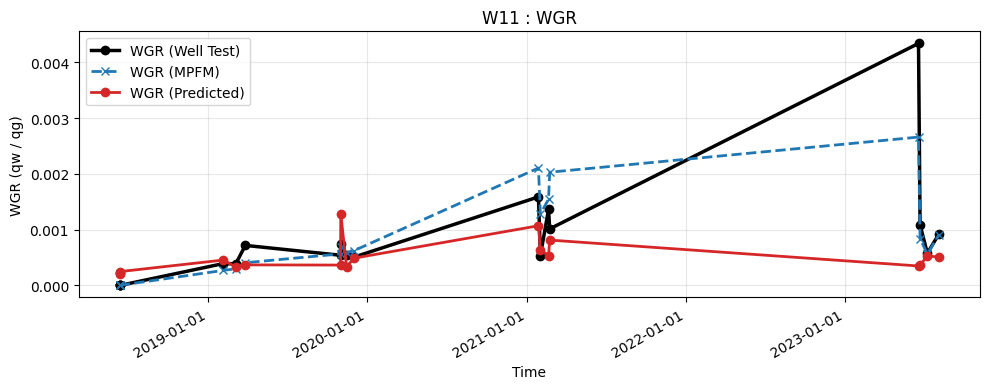

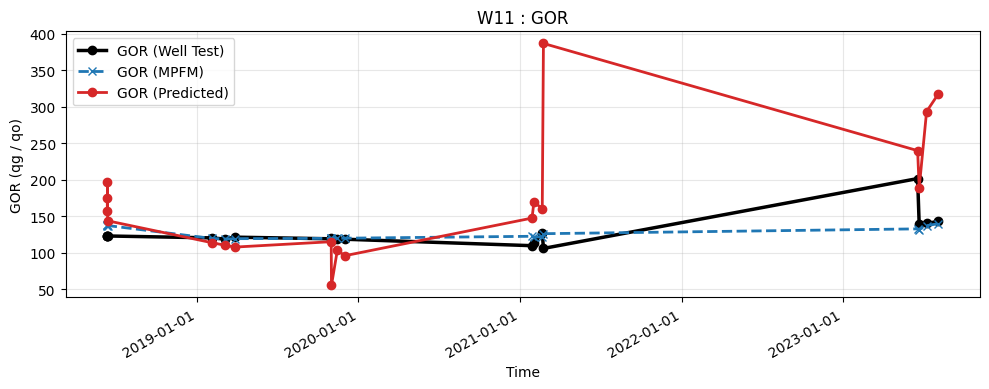

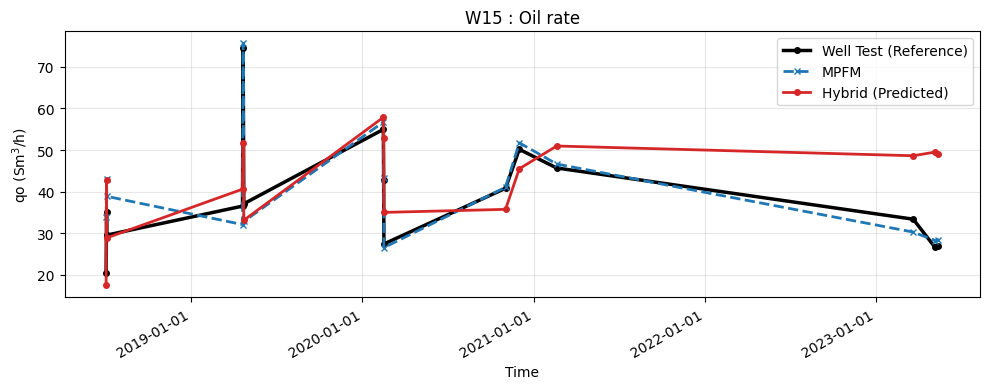

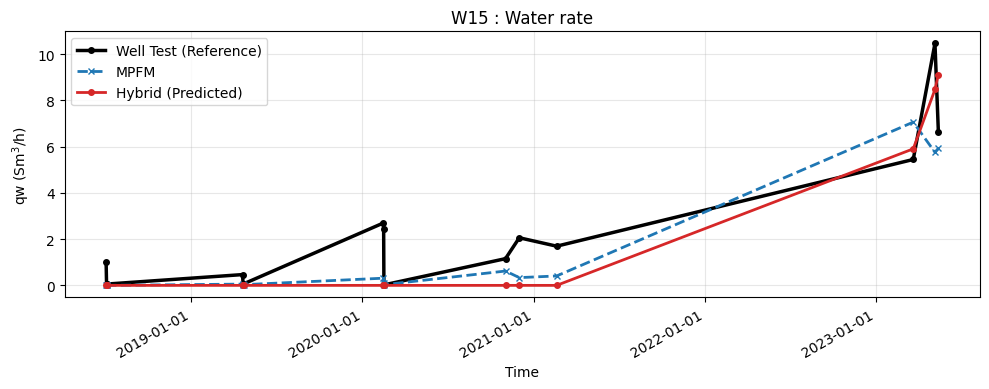

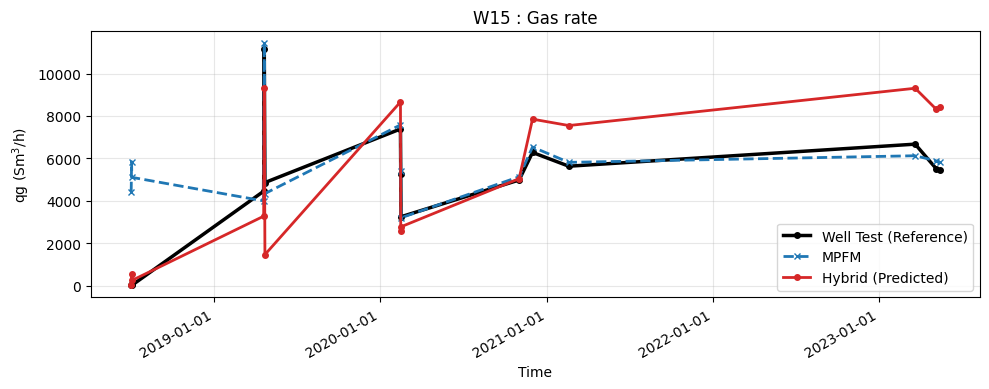

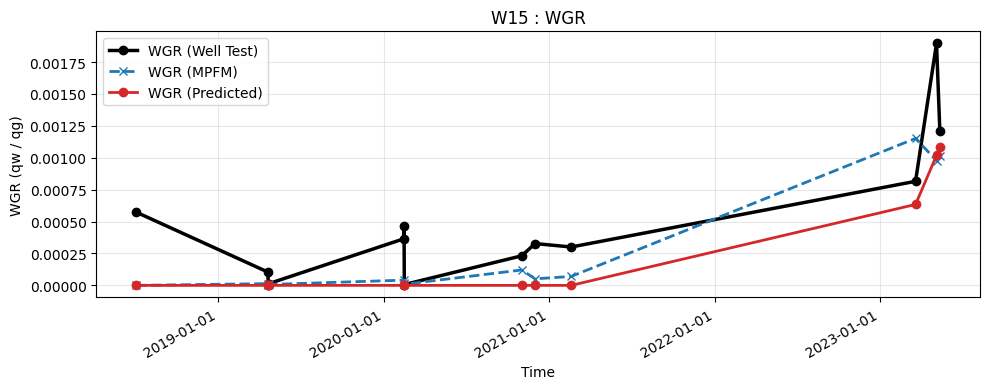

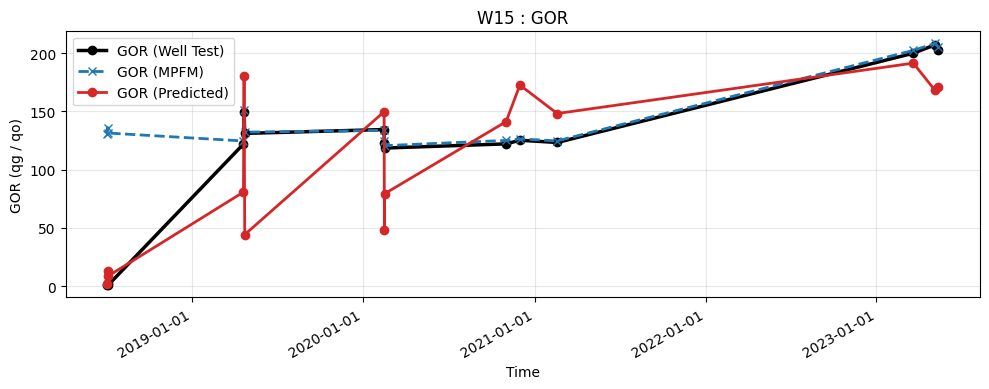

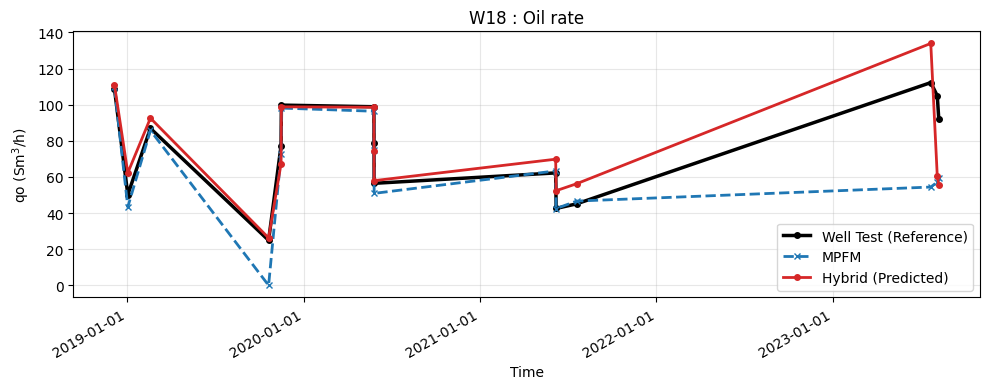

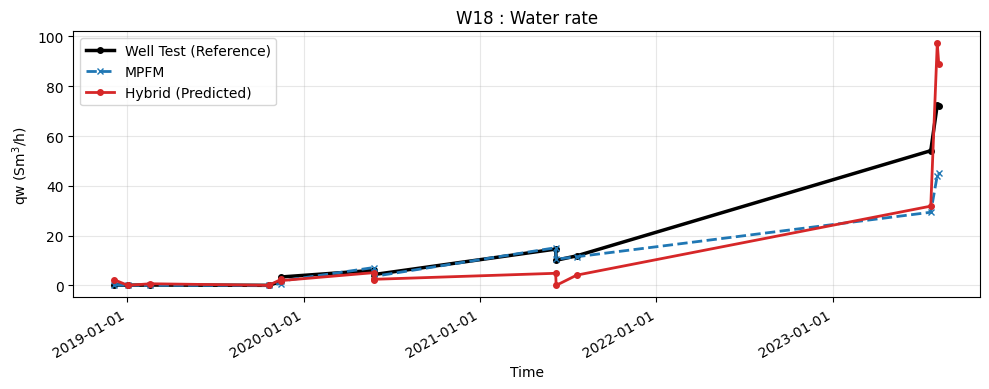

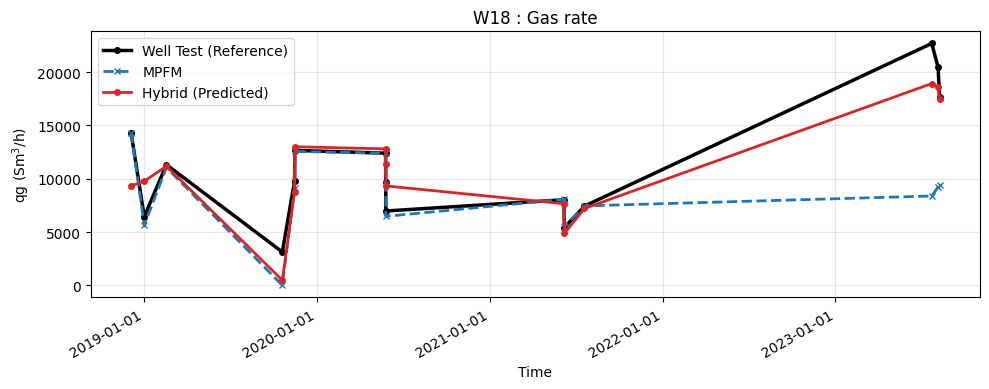

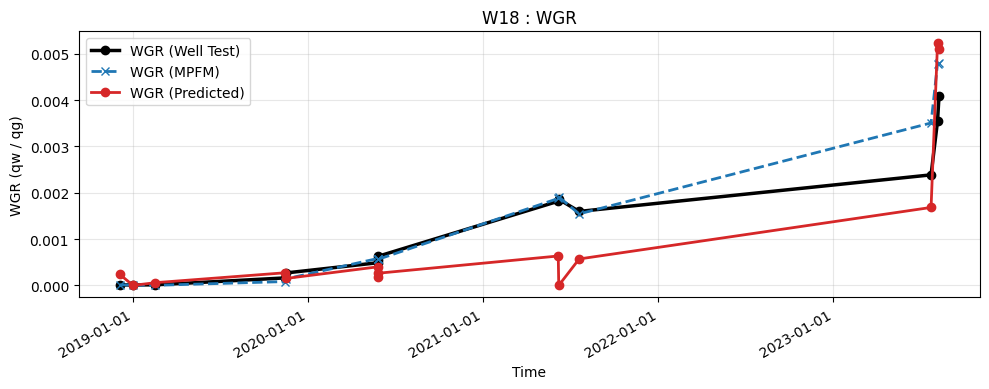

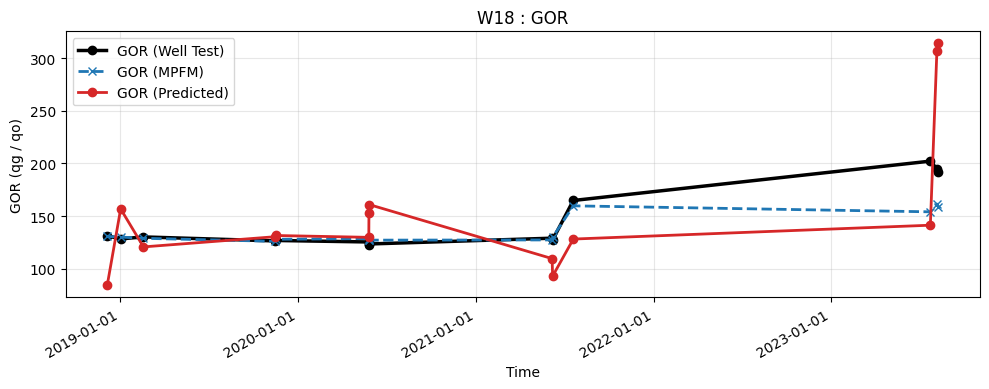

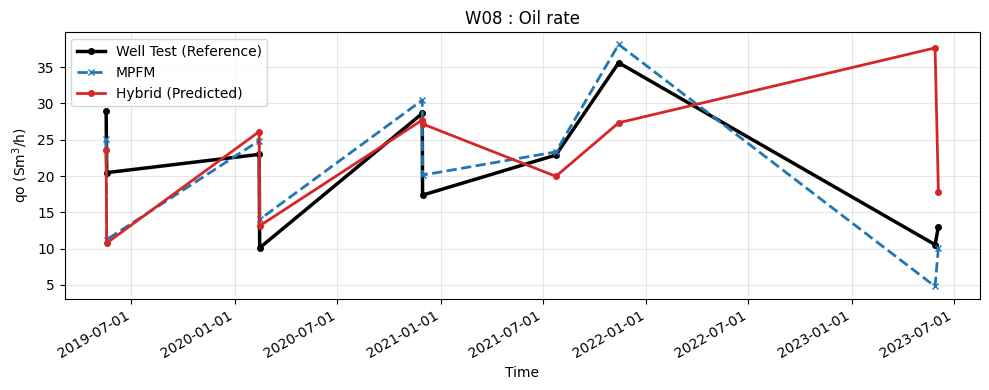

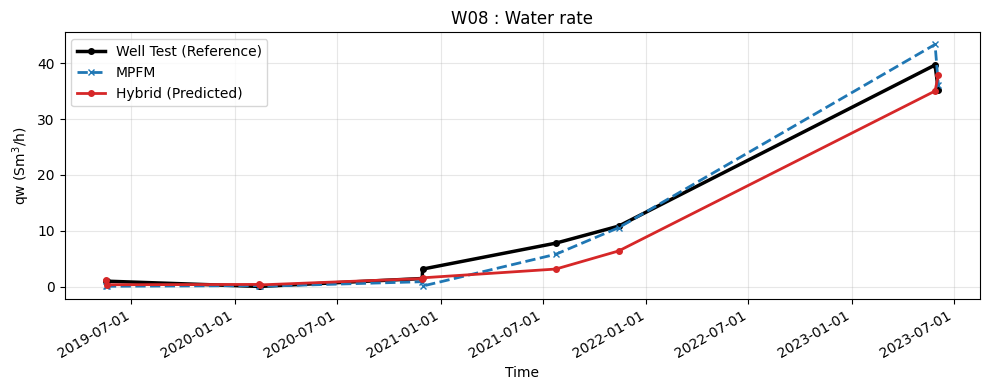

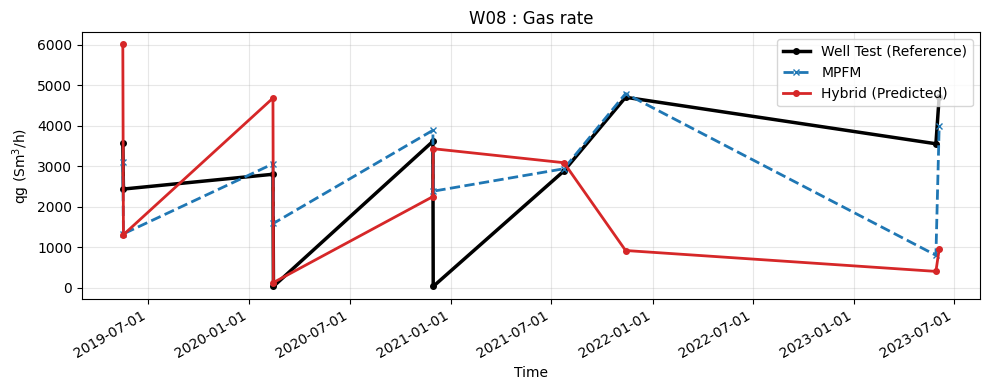

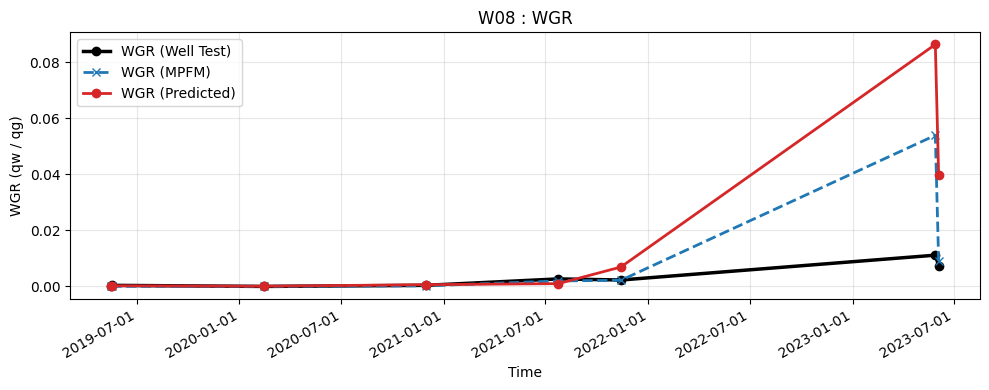

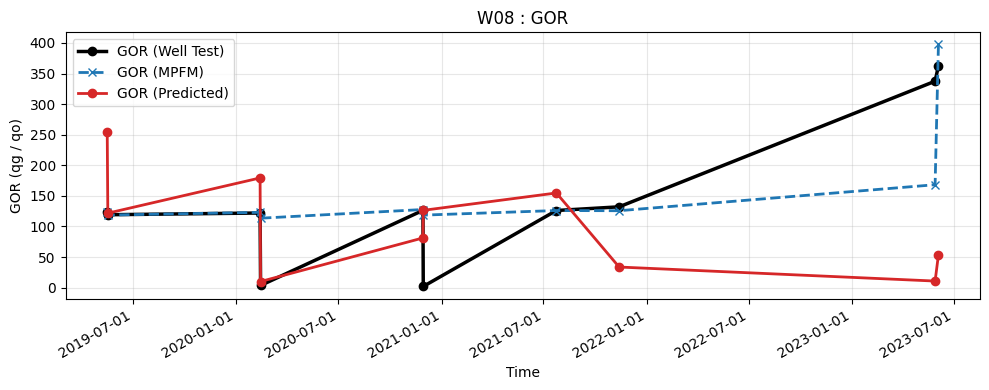

In [354]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [355]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"{len(df_train_lowo)}, {len(df_val_lowo)}, {len(df_calibration_lowo)}, {len(df_test_lowo)}")

418, 116, 25, 196


In [356]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=None)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.8493


In [357]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [358]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.3007324038007282,
   'mae': 19.671250599514302,
   'rmse': 27.425013256306936,
   'mape (%)': 23.729222886791476,
   'mpe (%)': 16.200919302649687},
  'qw': {'r2': 0.09045088527697187,
   'mae': 3.1329638183920623,
   'rmse': 10.221091146746902,
   'mape (%)': 424954.81928096944,
   'mpe (%)': 424921.18942707},
  'qg': {'r2': 0.6733970497388879,
   'mae': 1680.971425847072,
   'rmse': 2395.831492502246,
   'mape (%)': 266.51430435323283,
   'mpe (%)': 254.95782527063287},
  'wgr': {'r2': -0.0053097039855032335,
   'mae': 0.00027366268543480433,
   'rmse': 0.0009544346349551461,
   'mape (%)': 103.93323639568968,
   'mpe (%)': 68.65215954770406},
  'gor': {'r2': -1.2920834916265602,
   'mae': 14.111506510429034,
   'rmse': 24.393124519642416,
   'mape (%)': 142.9964374235988,
   'mpe (%)': 123.76606631073228}}}

In [359]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.5802900905830262,
   'mae': 17.139316481513863,
   'rmse': 21.247104597195182,
   'mape (%)': 16.49692008220251,
   'mpe (%)': 9.726883348577664},
  'qw': {'r2': 0.1822650059898816,
   'mae': 3.5077658344377407,
   'rmse': 9.69148828276035,
   'mape (%)': 244236.41693179484,
   'mpe (%)': 244137.20795752679},
  'qg': {'r2': 0.6771673600367094,
   'mae': 1826.9586089679226,
   'rmse': 2381.9625898063478,
   'mape (%)': 132.06449997743067,
   'mpe (%)': 128.45458014508932},
  'wgr': {'r2': 0.02976081666084507,
   'mae': 0.000312185375476159,
   'rmse': 0.000937638989882473,
   'mape (%)': 90.59976386207967,
   'mpe (%)': -19.758957558003008},
  'gor': {'r2': -1.386343454800265,
   'mae': 17.431430613145658,
   'rmse': 24.889644349663502,
   'mape (%)': 122.21953612095294,
   'mpe (%)': 111.48324957662696}}}

In [360]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9588130717389175,
   'mae': 4.033600816842719,
   'rmse': 6.697322080021378,
   'mape (%)': 3.393361376806472,
   'mpe (%)': 0.9981725806978549},
  'qw': {'r2': 0.9263637074899432,
   'mae': 2.5068894027591133,
   'rmse': 2.9355325610183396,
   'mape (%)': 579347.9002410582,
   'mpe (%)': 579334.21062041},
  'qg': {'r2': 0.9412707355360578,
   'mae': 520.8714687175346,
   'rmse': 1022.3903824214965,
   'mape (%)': 448.6297978892727,
   'mpe (%)': 447.8015820750989},
  'wgr': {'r2': 0.9496966174805719,
   'mae': 0.00017146188119526308,
   'rmse': 0.00021567400323933345,
   'mape (%)': 142.44468953082773,
   'mpe (%)': 128.80123287080397},
  'gor': {'r2': 0.13797918466097225,
   'mae': 7.95289409444641,
   'rmse': 15.113797457762514,
   'mape (%)': 456.1672216475437,
   'mpe (%)': 452.4619453374881}}}

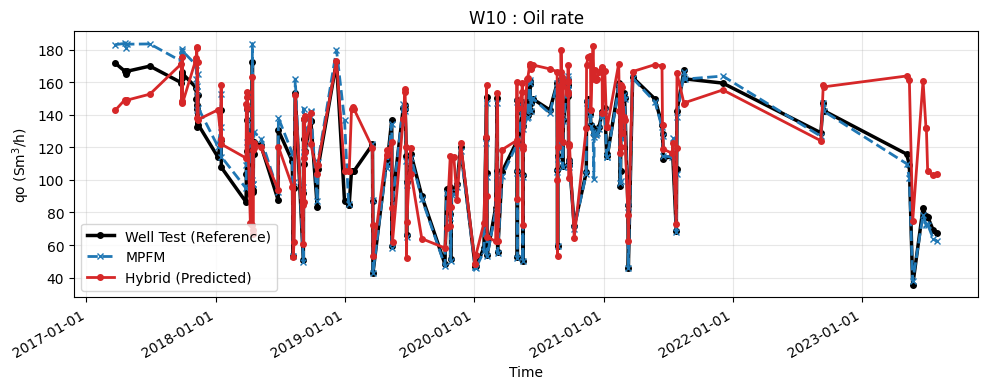

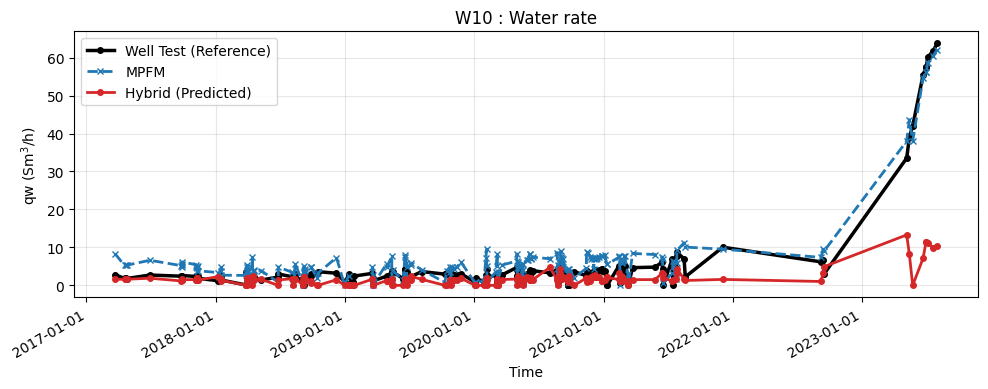

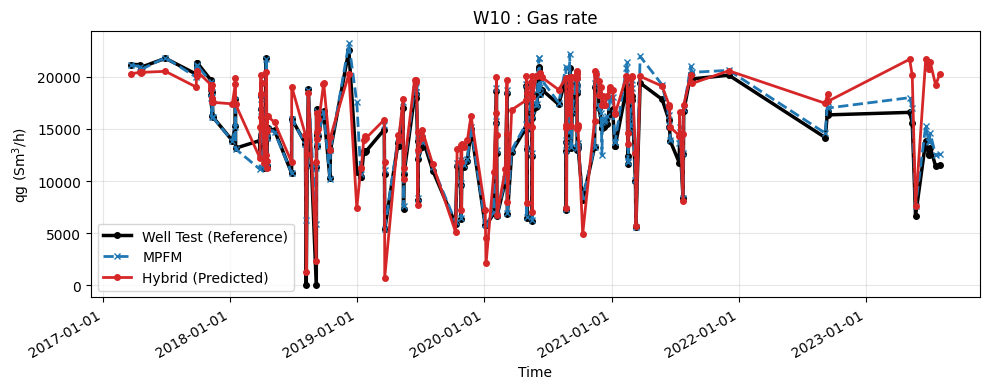

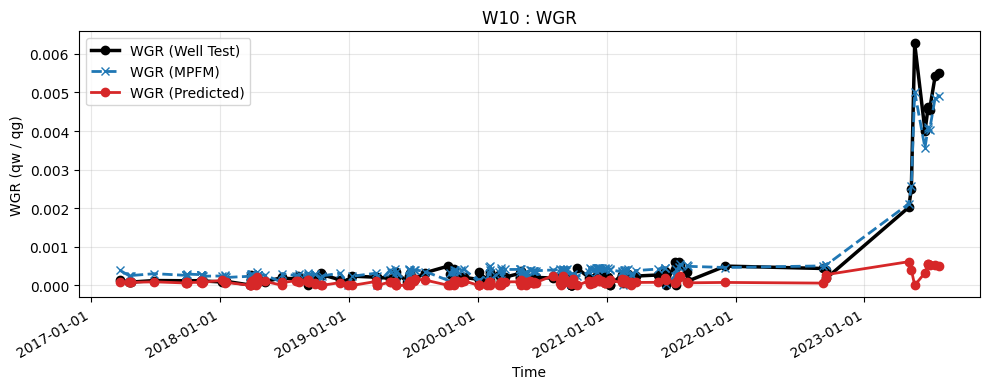

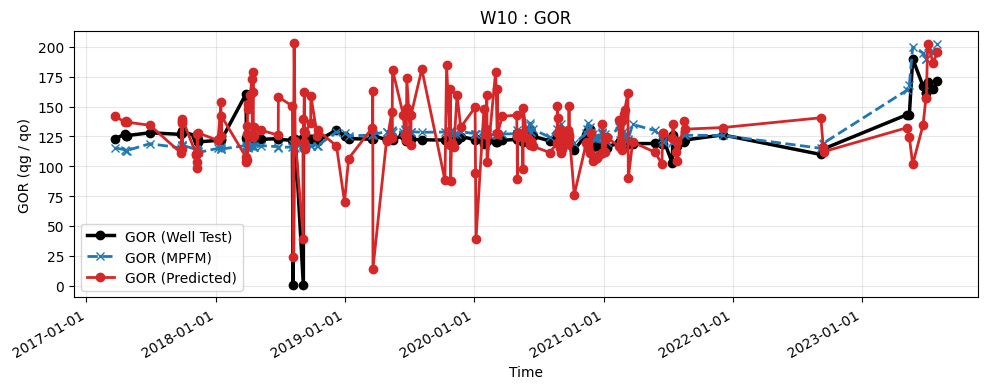

In [361]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [362]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [363]:
# df_resampled.index

In [364]:
# df_resampled.columns

In [365]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [366]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [367]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [368]:
# summarize_null(df_generated)